This notebook performs the pre-analysis workflow for low background data (trigger 2).
<br>
The process involves:
- Loading of reconstructed data.
- Correction of energy using $^{83\text{m}}Kr$ maps (FALTA USAR EL FACTOR DE ESCALA DE HE).
- Data cleaning to mitigate artifacts or anomalies arising from the NEXT reconstruction process.
- Application of cuts on $S1$ and $S2$ signals. 
- Differentiation and isolation of alpha ($\alpha$) and electron ($e$) populations.
- Cleaning of isolated clusters of hits.
- Generation of dataframes organized by analysis stage (hit and event-level), particle type ($\alpha$ and $e$).
- Application of selection criteria to separate populations into detector sub-volumes of interest.
- Storage of the processed and categorized information into a single output file per run for subsequent analysis phases.

# Configuration

In [10]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis')

from libs import crudo
from libs import fit_functions as ff
from libs import plotting_tools as pt

from invisible_cities.reco.corrections import read_maps
from invisible_cities.reco.corrections import apply_all_correction
from invisible_cities.types.symbols    import NormStrategy
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image

# Styling Plot
pt.ccortesp_plot_style()
PRELIM_LOGO = np.asarray(Image.open('/lhome/ific/c/ccortesp/Analysis/images/next_logo_preliminary.png'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# ==============================================================================
# CONFIGURATION CELL
# Adjust the parameters in this cell to configure the analysis workflow.
# ==============================================================================

# 1. RUN SELECTION
# -----------------
# Define which run(s) to process. This list will override the large 'runs_info' dictionary for selection.
# Example for a single run: RUNS_TO_PROCESS = [15478]
# Example for multiple runs: RUNS_TO_PROCESS = [15619, 15621, 15622, 15623, 15624]
RUNS_TO_PROCESS = [15737]

# 2. ANALYSIS PARAMETERS
# ----------------------
V_DRIFT = 0.865     # Drift velocity in [mm/μs]

# --- S1 Signal Cuts ---
# Po-like events are filtered using: S1h >= m * S1e + b
M_NOPOLIKE = 0.17
B_NOPOLIKE = -56

# --- S1e Correction ---
DT_STOP = 1372.2543          # Cathode temporal position in [μs]
CV_FIT  = [0.57, 796.53]     # Fit values for S1e correction vs DT

# --- Alpha/Electron Separation Cut ---
# Events with total corrected energy above this threshold are classified as alphas.
ENERGY_THRESHOLD = 3.0       # in [MeV]

# --- Electron Hit Cleaning Cut ---
# Minimum neighbors hits to define a valid cluster.
N_HITS = 5
# Minimum Q charge to activate a SiPM (P1 = 7 pe, P2 = 5 pe).
Q_THRESHOLD = 5        # in [pe]

# --- Alpha Hit Cleaning Cut ---
# In the alpha population, hits with charge below this value are removed.
Q_LIM_ALPHA = 100      # in [pe]

# --- Trigger 2 Efficiency Cut ---
# Events with event-level energy below this are removed to account for trigger efficiency.
TRG2_THRESHOLD = 0.5   # in [MeV]

# 3. DETECTOR REGIONS
# -------------------
# Geometric boundaries for event classification.
Z_LOW = 40          # in [mm]
Z_UP  = 1147        # in [mm]
R_UP  = 451.65      # in [mm]

# 4. OUTPUT FILENAME TAG
# ----------------------
# This tag will be added to the output HDF5 filename to version the analysis.
# Avoids overwriting previous results and helps keep track of different cut configurations.
# Example tags: '_other', '_p2_nhit5', '_nhit5_Qthres7' (this is basically p1_nhit5)
VERSION_TAG = '_p2_nhit5'

# 5. DATA DIRECTORIES
# -------------------
DATA_DIR   = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Sophronia/Low_background/'
ICAROS_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Icaros/Low_background/'
OUTPUT_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/runs/'

# --- Summary txt file ---
OUTPUT_TXT = 'summary' + VERSION_TAG +'.txt'

# Preliminary

In [12]:
# List of low background runs
runs_info = {
                # Condition 0:  castle = open #
                15062: {"duration": 84783, "OK": 69564, "LOST": 1339},
                15063: {"duration": 79120, "OK": 65052, "LOST": 1241},
                15076: {"duration": 69316, "OK": 56775, "LOST": 1080},
                # Condition 1:  castle = pclosed & RAS = on #
                15288: {"duration": 87256, "OK": 30201, "LOST": 8397},
                15289: {"duration": 82152, "OK": 28180, "LOST": 7884},
                15290: {"duration": 61295, "OK": 20931, "LOST": 5915},
                # Condition 2:  castle = pclosed & RAS = off #
                15299: {"duration": 60204, "OK": 18014, "LOST": 8929},
                15318: {"duration": 86706, "OK": 28735, "LOST": 1011},
                15319: {"duration": 85823, "OK": 27973, "LOST": 1008},
                15330: {"duration": 86462, "OK": 28157, "LOST": 1043},
                15331: {"duration": 85389, "OK": 27390, "LOST": 9966},
                15332: {"duration": 67758, "OK": 22010, "LOST": 8142},      # Loosely estimated
                15462: {"duration": 39365, "OK": 12847, "LOST": 4532},
                15472: {"duration": 86563, "OK": 28505, "LOST": 1001},      # Loosely estimated
                15478: {"duration": 86835, "OK": 28702, "LOST": 9999},
                15479: {"duration": 86876, "OK": 28713, "LOST": 1003},
                15484: {"duration": 86538, "OK": 28188, "LOST": 1046},
                15485: {"duration": 86186, "OK": 28281, "LOST": 1030},
                15486: {"duration": 86578, "OK": 28700, "LOST": 1036},
                15487: {"duration": 86456, "OK": 28703, "LOST": 9952},
                15488: {"duration": 86367, "OK": 28891, "LOST": 1004},
                15489: {"duration": 60554, "OK": 20059, "LOST": 7031},
                # Condition 3:  castle = closed & RAS = on #
                15502: {"duration": 85477, "OK": 28287, "LOST": 9564},
                15504: {"duration": 85194, "OK": 28297, "LOST": 9537},
                15505: {"duration": 86517, "OK": 28632, "LOST": 9725},
                15506: {"duration": 84841, "OK": 28438, "LOST": 9603},
                15507: {"duration": 55740, "OK": 18569, "LOST": 6149},
                15514: {"duration": 59207, "OK": 20054, "LOST": 6646},
                15519: {"duration": 34045, "OK": 11420, "LOST": 3646},
                15520: {"duration": 85170, "OK": 28050, "LOST": 9130},
                15521: {"duration": 85388, "OK": 28396, "LOST": 8831},
                15527: {"duration": 69725, "OK": 23560, "LOST": 7411},
                15528: {"duration": 41361, "OK": 13460, "LOST": 4426},
                15535: {"duration": 84904, "OK": 28799, "LOST": 9156},
                15539: {"duration": 56567, "OK": 15618, "LOST": 9586},
                15540: {"duration": 67663, "OK": 22526, "LOST": 7066},
                15541: {"duration": 86630, "OK": 29124, "LOST": 9333},
                15542: {"duration": 87915, "OK": 29717, "LOST": 9274},
                15543: {"duration": 86570, "OK": 29160, "LOST": 9123},
                15544: {"duration": 86566, "OK": 29498, "LOST": 9029},
                15545: {"duration": 85892, "OK": 29437, "LOST": 8877},
                15546: {"duration": 84822, "OK": 28663, "LOST": 8704},
                15547: {"duration": 71594, "OK": 24549, "LOST": 7421},
                15557: {"duration": 66088, "OK": 22273, "LOST": 6929},

                # ----- P E R I O D  0 2 ----- #
                
                # Jul 2025: castle = closed & RAS = off #
                15609: {"duration": 79563, "OK": 28168, "LOST": 8392},
                15614: {"duration": 81279, "OK": 28543, "LOST": 8472},
                15615: {"duration": 86302, "OK": 30165, "LOST": 9046},
                15616: {"duration": 86146, "OK": 30386, "LOST": 8635},
                15617: {"duration": 88041, "OK": 31274, "LOST": 8983},
                15618: {"duration": 82577, "OK": 29104, "LOST": 8619},
                15619: {"duration": 77964, "OK": 27411, "LOST": 7930},
                15621: {"duration": 83287, "OK": 29261, "LOST": 8351},
                15622: {"duration": 90371, "OK": 31543, "LOST": 9167},
                15623: {"duration": 80748, "OK": 28474, "LOST": 8300},
                15624: {"duration": 64650, "OK": 22921, "LOST": 6461},
                # Aug 2025: castle = closed & RAS = on #
                15625: {"duration": 87329, "OK": 30498, "LOST": 8570},
                15626: {"duration": 107092, "OK": 37665, "LOST": 10446},
                15627: {"duration": 61872, "OK": 21967, "LOST": 6238},
                15632: {"duration": 86709, "OK": 30444, "LOST": 8826},
                15633: {"duration": 86076, "OK": 30070, "LOST": 8578},
                15634: {"duration": 86545, "OK": 30372, "LOST": 8234},
                15635: {"duration": 87672, "OK": 30697, "LOST": 8537},
                15636: {"duration": 84284, "OK": 29394, "LOST": 8465},
                15637: {"duration": 76285, "OK": 26571, "LOST": 7422},
                15639: {"duration": 87347, "OK": 30861, "LOST": 8525},
                15640: {"duration": 30714, "OK": 10700, "LOST": 3170},
                15642: {"duration": 25075, "OK": 8722 , "LOST": 2437},
                15643: {"duration": 89049, "OK": 31554, "LOST": 8674},
                15644: {"duration": 85486, "OK": 30518, "LOST": 8297},
                15645: {"duration": 85729, "OK": 30510, "LOST": 8318}, 
                15647: {"duration": 86629, "OK": 30767, "LOST": 8406},
                15648: {"duration": 86466, "OK": 31033, "LOST": 8393},
                15649: {"duration": 86270, "OK": 30639, "LOST": 8153},
                15650: {"duration": 22096, "OK": 8044 , "LOST": 2227},
                15655: {"duration": 80788, "OK": 28802, "LOST": 7950},
                15656: {"duration": 85998, "OK": 30696, "LOST": 8311},
                15657: {"duration": 86237, "OK": 30399, "LOST": 8587},
                15658: {"duration": 86032, "OK": 30601, "LOST": 8224},
                15659: {"duration": 86242, "OK": 31012, "LOST": 8390},
                # 15660: {"duration": 85797, "OK": 31112, "LOST": 8269},    # Failed run due to SiPM overcurrent
                # 15661: {"duration": 76792, "OK": 27556, "LOST": 7183},    # Failed run due to SiPM overcurrent
                # 15667: {"duration": 46716, "OK": 16472, "LOST": 4611},    # Failed run due to SiPM overcurrent
                15669: {"duration": 81128, "OK": 28934, "LOST": 8059},
                15670: {"duration": 86214, "OK": 31038, "LOST": 8499},
                15671: {"duration": 86950, "OK": 31309, "LOST": 8268},
                15672: {"duration": 86315, "OK": 31207, "LOST": 8214},
                # Sep 2025
                15673: {"duration": 81544, "OK": 29419, "LOST": 7850},
                15675: {"duration": 85817, "OK": 30257, "LOST": 8928},
                15676: {"duration": 79211, "OK": 28268, "LOST": 8289},
                # 15679: {"duration": 83742, "OK": 29177, "LOST": 9790},    # Afected run due to RAS issues
                # 15680: {"duration": 85296, "OK": 29183, "LOST": 9747},    # Afected run due to RAS issues
                15681: {"duration": 86023, "OK": 29606, "LOST": 9625},
                15682: {"duration": 65708, "OK": 22534, "LOST": 7483},
                15687: {"duration": 86309, "OK": 29497, "LOST": 10048},
                15688: {"duration": 86399, "OK": 29702, "LOST": 10080},
                15689: {"duration": 85830, "OK": 29836, "LOST": 10086},
                15693: {"duration": 86133, "OK": 29546, "LOST": 9912},
                15694: {"duration": 86542, "OK": 29877, "LOST": 9894},
                15695: {"duration": 86075, "OK": 30004, "LOST": 9982},
                15696: {"duration": 87682, "OK": 30263, "LOST": 10084},
                15697: {"duration": 86373, "OK": 29462, "LOST": 9872},
                15698: {"duration": 90027, "OK": 31671, "LOST": 10056},
                15699: {"duration": 86278, "OK": 30129, "LOST": 9810},
                15700: {"duration": 86613, "OK": 30194, "LOST": 9827},
                15701: {"duration": 87385, "OK": 28775, "LOST": 9605},      # Data hang!
                15709: {"duration": 57503, "OK": 20381, "LOST": 6441},      # PMT failed completely
                15724: {"duration": 66550, "OK": 23477, "LOST": 7439},
                15729: {"duration": 85812, "OK": 30016, "LOST": 9663},
                15730: {"duration": 87572, "OK": 30329, "LOST": 9960},
                15731: {"duration": 86561, "OK": 30155, "LOST": 9790},
                15732: {"duration": 85314, "OK": 29641, "LOST": 9508},
                15733: {"duration": 86919, "OK": 30475, "LOST": 10027},
                15734: {"duration": 85790, "OK": 29837, "LOST": 9598},
                15735: {"duration": 87451, "OK": 30547, "LOST": 9958},
                15736: {"duration": 93376, "OK": 32622, "LOST": 10506},
                15737: {"duration": 52343, "OK": 18365, "LOST": 5844},
            }

In [13]:
# Paths of the tables inside the HDF5 file. These are the keys used to access the datasets
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

# Columns to be used for the analysis
doro_columns = ['event', 'time', 'nS1', 'nS2', 'S1h', 'S1e', 'S2e', 'DT', 'X', 'Y', 'Z']
soph_columns = ['event', 'time', 'npeak', 'X', 'Y', 'Z', 'Q', 'E']

### Dataframes Categorization

In [55]:
# Store the loaded data here
reco_data = {run_id: {
                        'Dorothea' : {'All': {}, 'Alpha': {}, 'Electron': {}},
                        'Sophronia': {'All': {}, 'Alpha': {}, 'Electron': {}},
                        'Event':     {           'Alpha': {}, 'Electron': {}} 
                    } 
            for run_id in RUNS_TO_PROCESS}

In [48]:
# Store the selected data here
sel_data = {run_id: {
                        'Sophronia': {'Alpha'   : {'Inclusive': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}, 
                                      'Electron': {'Inclusive': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}},
                        'Event':     {'Alpha'   : {'Inclusive': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}, 
                                      'Electron': {'Inclusive': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}}
                    } 
            for run_id in RUNS_TO_PROCESS}


# Reconstruction

Load the data as it comes from the NEXT reconstruction chain. 
<br>
We store the number of reconstructed events for extra plots in the future.

In [9]:
CUT_NAMES = ['Reconstructed', 'Clean', 'S1_Cut', 'S2_Cut']        # QUIZÁ SIN EL OK NI EL LOST
ELEC_CUT_NAMES  = ['nElectron', 'nElectron_Clean', 'nElectron_Trg2', 'nElectron_Fiducial', 'nElectron_Tube', 'nElectron_Cathode', 'nElectron_Anode']
ALPHA_CUT_NAMES = ['nAlpha', 'nAlpha_Clean', 'nAlpha_Trg2', 'nAlpha_Fiducial', 'nAlpha_Tube', 'nAlpha_Cathode', 'nAlpha_Anode']

local_cut_counts = {name: 0 for name in CUT_NAMES + ELEC_CUT_NAMES + ALPHA_CUT_NAMES}

print(local_cut_counts)

local_cut_counts[ELEC_CUT_NAMES[2]] = 100

print(local_cut_counts)

{'Reconstructed': 0, 'Clean': 0, 'S1_Cut': 0, 'S2_Cut': 0, 'nElectron': 0, 'nElectron_Clean': 0, 'nElectron_Trg2': 0, 'nElectron_Fiducial': 0, 'nElectron_Tube': 0, 'nElectron_Cathode': 0, 'nElectron_Anode': 0, 'nAlpha': 0, 'nAlpha_Clean': 0, 'nAlpha_Trg2': 0, 'nAlpha_Fiducial': 0, 'nAlpha_Tube': 0, 'nAlpha_Cathode': 0, 'nAlpha_Anode': 0}
{'Reconstructed': 0, 'Clean': 0, 'S1_Cut': 0, 'S2_Cut': 0, 'nElectron': 0, 'nElectron_Clean': 0, 'nElectron_Trg2': 100, 'nElectron_Fiducial': 0, 'nElectron_Tube': 0, 'nElectron_Cathode': 0, 'nElectron_Anode': 0, 'nAlpha': 0, 'nAlpha_Clean': 0, 'nAlpha_Trg2': 0, 'nAlpha_Fiducial': 0, 'nAlpha_Tube': 0, 'nAlpha_Cathode': 0, 'nAlpha_Anode': 0}


In [56]:
# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # Run information
    run_OK = runs_info[run_id]['OK']

    # Initialize empty lists to store the dataframes
    run_dst  = []
    run_reco = []
    reco_evts = 0

    # ----- LDC Loop ----- #
    for ldc in range(1, 8):

        # Load the HDF5 file
        h5_path = os.path.join(DATA_DIR, f'run_{run_id}_ldc{ldc}_trg2_sophronia.h5')

        try:

            # ----- Dorothea ----- #
            dst_df = pd.read_hdf(h5_path, key=dorothea)
            dst_df = dst_df.loc[:, doro_columns]    # Select only the necessary columns
            reco_evts += dst_df['event'].nunique()     # Number of reco events
            run_dst.append(dst_df)

            # ----- Sophronia ----- #
            reco_df = pd.read_hdf(h5_path, key=sophronia)
            reco_df = reco_df.loc[:, soph_columns]  # Select only the necessary columns
            run_reco.append(reco_df)

        except KeyError as e:
            print(f"Warning: Key '{e.args[0]}' not found in file '{h5_path}'. Skipping this file.")

    runs_info[run_id]['Reco_CV'] = int(reco_evts)
    print(f'  Loaded: {reco_evts} events ({reco_evts/run_OK:.2%})')

    # ----- Concatenate Data ----- #
    run_dst_df  = pd.DataFrame()
    run_reco_df = pd.DataFrame()

    if run_dst:
        run_dst_df = pd.concat(run_dst, ignore_index=True)

    if run_reco:
        run_reco_df = pd.concat(run_reco, ignore_index=True)

    # ----- Save Combined Data ----- #
    reco_data[run_id]['Dorothea']['All']  = run_dst_df
    reco_data[run_id]['Sophronia']['All'] = run_reco_df

--- Processing Run 15737 ---
  Loaded: 18192 events (99.06%)


## Energy Correction & Cleaning Part 01

__Sophronia__
<br>
We need to correct the energy using the Kr result from Icaros for the corresponding run.

In [ ]:
# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_doro = reco_data[run_id]['Dorothea']['All']
    df_soph = reco_data[run_id]['Sophronia']['All']
    # Event counter
    evt_prior = df_doro['event'].nunique()
    # Rename column 'Z' to 'DT'
    df_soph.rename(columns={'Z': 'DT'}, inplace=True)

    # Kr map
    kr_file = next((f for f in os.listdir(ICAROS_DIR) if f'run_{run_id}' in f and f.endswith('.map.h5')), None)
    if not kr_file:
        raise FileNotFoundError(f"No Kr map file found for run {run_id} in {ICAROS_DIR}")
    kr_path = os.path.join(ICAROS_DIR, kr_file)
    cmap = read_maps(kr_path)

    # Apply corrections
    corr_func = apply_all_correction(cmap, apply_temp=False, norm_strat=NormStrategy.kr)

    # ----- Energy Correction ----- #
    df_soph['corr_factor'] = corr_func(df_soph.X, df_soph.Y, df_soph.Z, df_soph.time)
    df_soph['E_corr'] = df_soph['E'] * df_soph['corr_factor']

    # ---- Cleaning 01 ----- #
    # NaN or negative energy to 0: hit-level
    df_soph['E_corr'] = np.where(
                                    pd.notna(df_soph['E_corr']) & (df_soph['E_corr'] > 0),      # Condition
                                    df_soph['E_corr'],                                          # Value if condition is True
                                    0                                                           # Value if condition is False   
    )

    # Drop events with negative Z: event-level
    Znegative_evt_ids = df_soph.loc[df_soph['DT'] < 0, 'event'].unique()

    if Znegative_evt_ids.size > 0:
        df_soph = df_soph[~df_soph['event'].isin(Znegative_evt_ids)].copy()

    # Compute real Z position: using the drift velocity
    df_soph['Z'] = df_soph['DT'] * V_DRIFT

    # ----- Good Events ID: Part 01 ----- #
    good_evt_ids = df_soph['event'].unique()
    runs_info[run_id]['After_Zneg'] = len(good_evt_ids)
    print(f"  After drop negative Z: {len(good_evt_ids)} events ({len(good_evt_ids)/evt_prior:.2%})")

    # ----- Store Data ----- #
    reco_data[run_id]['Dorothea']['All']  = df_doro[df_doro['event'].isin(good_evt_ids)].copy()     # Keep only events with good sophronia info
    reco_data[run_id]['Sophronia']['All'] = df_soph.copy()

--- Processing Run 15737 ---
  After drop negative Z: 13440 events (73.88%)


## $S1$ Signal

__Dorothea__
<br>
- __nS1 = 0__ : These are events associated to the _anode_!
- __nS1 = 1__ : We avoid the Po-like population (see $\alpha$ analysis in $\text{Xe}$) using the $S1$ height, and then, we correct the $S1$ energy.

In [58]:
# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_doro = reco_data[run_id]['Dorothea']['All']
    df_soph = reco_data[run_id]['Sophronia']['All']
    # Event counter
    evt_prior = df_doro['event'].nunique()

    # ----- Counters for Efficiencies ----- #
    nS1_0_evt_ids = df_doro.loc[df_doro['nS1'] == 0, 'event'].unique();   
    runs_info[run_id]['nS1_0'] = len(nS1_0_evt_ids)
    print(f"    nS1 = 0: {len(nS1_0_evt_ids)} events ({len(nS1_0_evt_ids)/evt_prior:.2%})")

    nS1_1_evt_ids = df_doro.loc[df_doro['nS1'] == 1, 'event'].unique()
    runs_info[run_id]['nS1_1'] = len(nS1_1_evt_ids);
    print(f"    nS1 = 1: {len(nS1_1_evt_ids)} events ({len(nS1_1_evt_ids)/evt_prior:.2%})")
    
    # ----- S1 Signal ----- #
    df_doro = df_doro[(df_doro['nS1'] == 0) | ((df_doro['nS1'] == 1) & (df_doro['S1h'] >= M_NOPOLIKE * df_doro['S1e'] + B_NOPOLIKE))].copy()

    # Events with S1 signal above the NO-Polike threshold
    nS1_NOPolike = df_doro.loc[df_doro['nS1'] == 1, 'event'].unique();      
    runs_info[run_id]['nS1_NOPolike'] = len(nS1_NOPolike)
    print(f"      NO Po-like: {len(nS1_NOPolike)} events ({len(nS1_NOPolike)/len(nS1_1_evt_ids):.2%})")

    # ----- S1e Correction ----- #
    df_doro = crudo.correct_S1e(df_doro, CV_FIT, DT_STOP, output_column='S1e_corr')    # I'll work with this corrected S1 energy
    # Check if the correction was applied
    if 'S1e_corr' not in df_doro.columns:
        print(f"Error: S1e correction not applied! Skipping...")
        continue

    # ----- Good Events ID ----- #
    good_evt_ids = df_doro['event'].unique()
    runs_info[run_id]['After_S1'] = len(good_evt_ids)
    print(f"  After S1 signal cuts: {len(good_evt_ids)} events ({len(good_evt_ids)/evt_prior:.2%})")

    # ----- Store Data ----- #
    reco_data[run_id]['Dorothea']['All']  = df_doro.copy()
    reco_data[run_id]['Sophronia']['All'] = df_soph[df_soph['event'].isin(good_evt_ids)].copy()


--- Processing Run 15737 ---
    nS1 = 0: 1456 events (10.83%)
    nS1 = 1: 11319 events (84.22%)
      NO Po-like: 9993 events (88.29%)
  After S1 signal cuts: 11449 events (85.19%)


## $S2$ Signal

__Dorothea__
<br>
- __nS2 = 1__ 

In [59]:
# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_doro = reco_data[run_id]['Dorothea']['All']
    df_soph = reco_data[run_id]['Sophronia']['All']
    # Event counter
    evt_prior = df_doro['event'].nunique()
    
    # ----- S2 Signal ----- #
    df_doro = df_doro[df_doro['nS2'] == 1].copy()

    # ----- Good Events ID ----- #
    good_evt_ids = df_doro['event'].unique()
    runs_info[run_id]['After_S2'] = len(good_evt_ids)
    print(f"  After S2 signal cut: {len(good_evt_ids)} events ({len(good_evt_ids)/evt_prior:.2%})")

    # ----- Store Data ----- #
    reco_data[run_id]['Dorothea']['All']  = df_doro.copy()
    reco_data[run_id]['Sophronia']['All'] = df_soph[df_soph['event'].isin(good_evt_ids)].copy()

--- Processing Run 15737 ---
  After S2 signal cut: 10223 events (89.29%)


## $\alpha$ and $e$ Populations

__Dorothea__
<br>
Now, let's define an appropiate value for the energy cut.
<br>
The precise cut value should be computed from the $S1e$ vs. $E$ plot using $^{228}\text{Th}$ data (because of stats).

### Using $S2e$

In [17]:
# # Global
# n_bins = 100
# x_min, x_max = 0, 2000e3
# x_edges = np.linspace(x_min, x_max, n_bins + 1)

# plt.figure(figsize=(8, 6))

# # ----- Run Loop ----- #
# for i, run_id in enumerate(RUNS_TO_PROCESS):

#     # Run information
#     run_long = runs_info[run_id]['duration']
#     run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

#     # Data
#     df_doro = reco_data[run_id]['Dorothea']['All']
    
#     # Variables
#     E = df_doro['S2e']

#     # Histogram: normalized by corrected DAQ data taking time
#     E_counts, E_edges = np.histogram(E, bins=x_edges)
#     E_rate = E_counts / (run_long * run_DAQe)

#     # ----- Plotting ----- #
#     plt.stairs(E_rate, E_edges, label=f'Run {run_id}', 
#                fill=False, lw=1.0, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# # S2 energy threshold
# x_flag = 750e3
# plt.axvline(x=x_flag, color='gray', ls='--', lw=1)
# plt.text(0.98*x_flag, 3.25e-2, f'{int(x_flag)} pe', c='gray', ha='right', va='bottom')

# # ----- Styling ----- #
# plt.xlabel('S2 Energy (PE)')
# plt.ylabel('Rate (Hz)')
# # plt.yscale('log')
# plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
# plt.legend(loc='best', fontsize=9)

# plt.grid(True, ls='--', lw=0.5, alpha=0.5)
# plt.gca().set_facecolor("whitesmoke")
# plt.show()

### Using $E_{corr}$

8.11204765004631


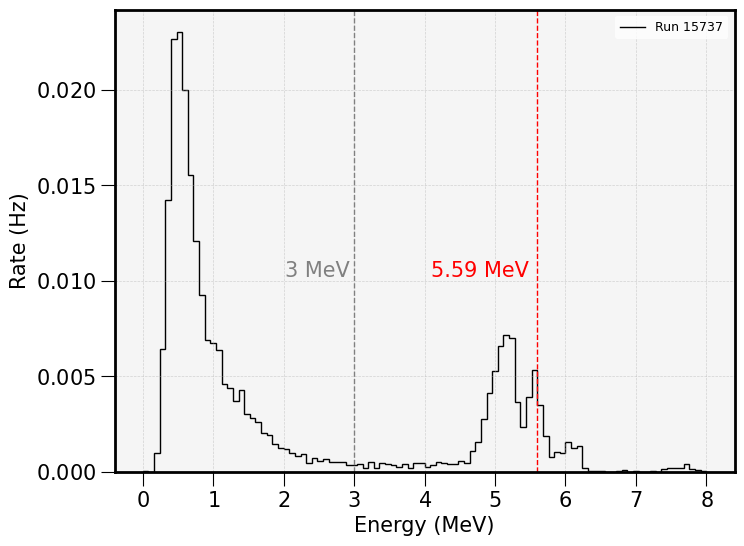

In [ ]:
# Global
n_bins = 100
x_min, x_max = 0, 8
x_edges = np.linspace(x_min, x_max, n_bins + 1)

plt.figure(figsize=(8, 6))

# ----- Run Loop ----- #
for i, run_id in enumerate(RUNS_TO_PROCESS):

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    # Data
    df_soph = reco_data[run_id]['Sophronia']['All']
    
    # Variables
    E = df_soph.groupby('event')['E_corr'].sum()

    # Histogram: normalized by corrected DAQ data taking time
    E_counts, E_edges = np.histogram(E, bins=x_edges)
    E_rate = E_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(E_rate, E_edges, label=f'Run {run_id}', 
            fill=False, lw=1.0, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# Rn peak as reference!
x_Rn = 5.59
plt.axvline(x=x_Rn, color='red', ls='--', lw=1)
plt.text(0.98*x_Rn, 1e-2, f'{x_Rn} MeV', c='red', ha='right', va='bottom')

# Energy threshold
x_flag = 3
plt.axvline(x=x_flag, color='gray', ls='--', lw=1)
plt.text(0.98*x_flag, 1e-2, f'{x_flag} MeV', c='gray', ha='right', va='bottom')

# ----- Styling ----- #
plt.xlabel('Energy (MeV)')
plt.ylabel('Rate (Hz)')
# plt.yscale('log')
plt.legend(loc='best', fontsize=9)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

The best option is using $E_{corr}$! But hey, you still see the shift in the energy spectrum.

In [19]:
# Apply selection
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_doro = reco_data[run_id]['Dorothea']['All']
    df_soph = reco_data[run_id]['Sophronia']['All']
    # Event counter
    evt_prior = df_doro['event'].nunique()

    # Variables
    evt_energy = df_soph.groupby('event')['E_corr'].sum()

    # Event IDs for alphas and electrons
    elec_ids  = evt_energy[evt_energy <= ENERGY_THRESHOLD].index
    alpha_ids = evt_energy[evt_energy >  ENERGY_THRESHOLD].index

    # ----- Storing Data ----- #
    reco_data[run_id]['Dorothea']['Electron'] = df_doro[df_doro['event'].isin(elec_ids)].copy()
    runs_info[run_id]['nElectron'] = len(elec_ids) 
    print(f"  Electron candidates: {len(elec_ids)} events ({len(elec_ids)/evt_prior:.2%}) ")

    reco_data[run_id]['Dorothea']['Alpha']    = df_doro[df_doro['event'].isin(alpha_ids)].copy()
    runs_info[run_id]['nAlpha'] = len(alpha_ids)
    print(f"  Alphas candidates: {len(alpha_ids)} events ({len(alpha_ids)/evt_prior:.2%}) ")

    reco_data[run_id]['Sophronia']['Electron'] = df_soph[df_soph['event'].isin(elec_ids)].copy()
    reco_data[run_id]['Sophronia']['Alpha']    = df_soph[df_soph['event'].isin(alpha_ids)].copy()

--- Processing Run 15729 ---
  Electron candidates: 11733 events (72.30%) 
  Alphas candidates: 4496 events (27.70%) 
--- Processing Run 15730 ---
  Electron candidates: 12135 events (72.37%) 
  Alphas candidates: 4633 events (27.63%) 
--- Processing Run 15731 ---
  Electron candidates: 11903 events (72.16%) 
  Alphas candidates: 4593 events (27.84%) 
--- Processing Run 15732 ---
  Electron candidates: 11843 events (72.26%) 
  Alphas candidates: 4546 events (27.74%) 
--- Processing Run 15733 ---
  Electron candidates: 12087 events (72.66%) 
  Alphas candidates: 4549 events (27.34%) 
--- Processing Run 15734 ---
  Electron candidates: 11888 events (72.80%) 
  Alphas candidates: 4442 events (27.20%) 
--- Processing Run 15735 ---
  Electron candidates: 12225 events (72.98%) 
  Alphas candidates: 4526 events (27.02%) 
--- Processing Run 15736 ---
  Electron candidates: 13193 events (72.76%) 
  Alphas candidates: 4938 events (27.24%) 
--- Processing Run 15737 ---
  Electron candidates: 7322

Let's see now the energy spectrum

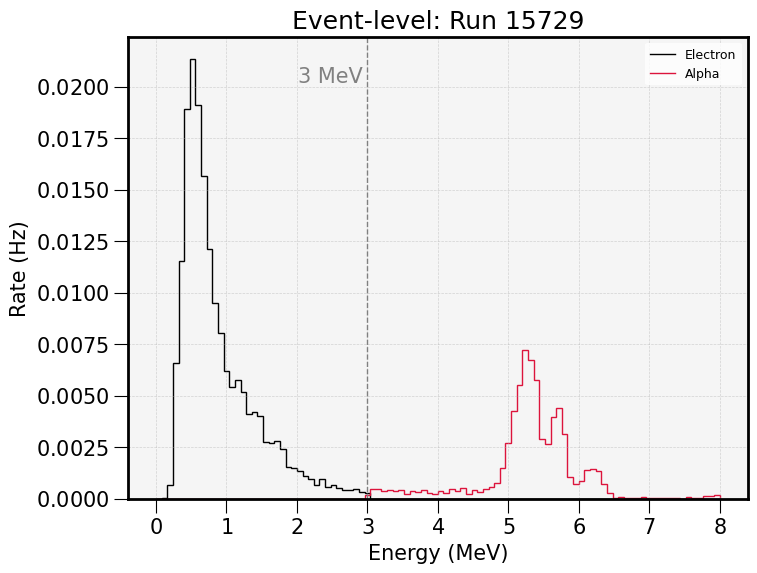

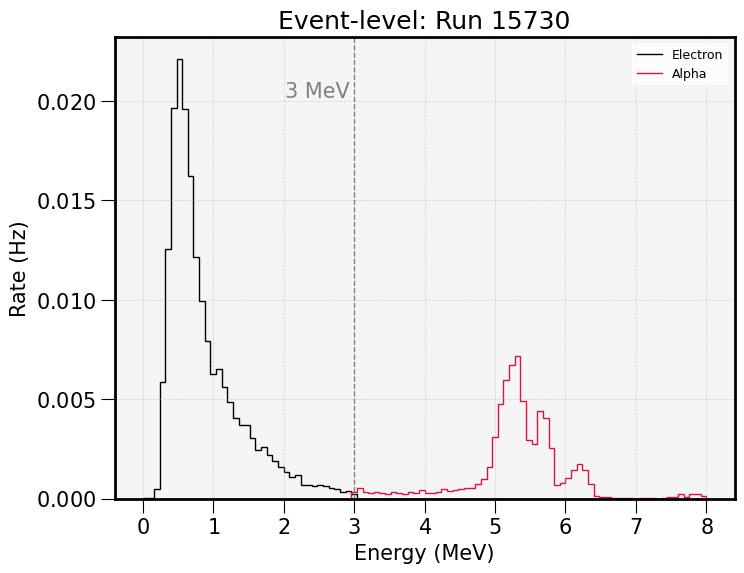

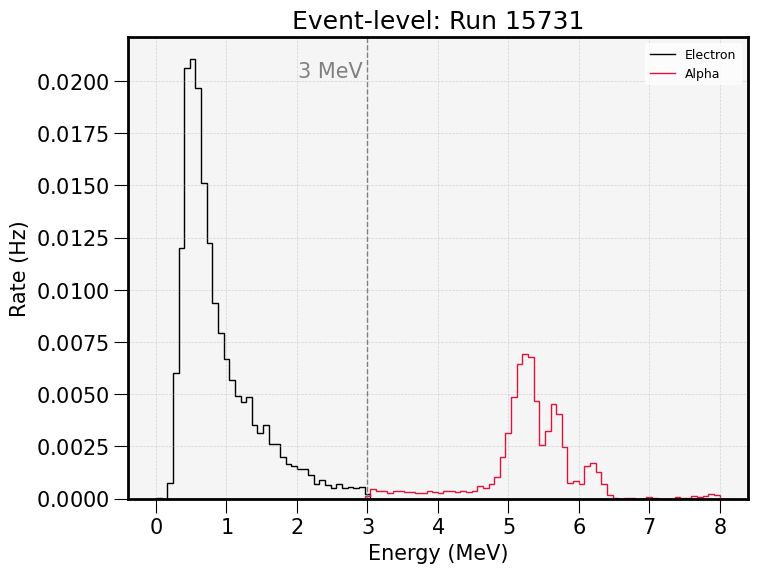

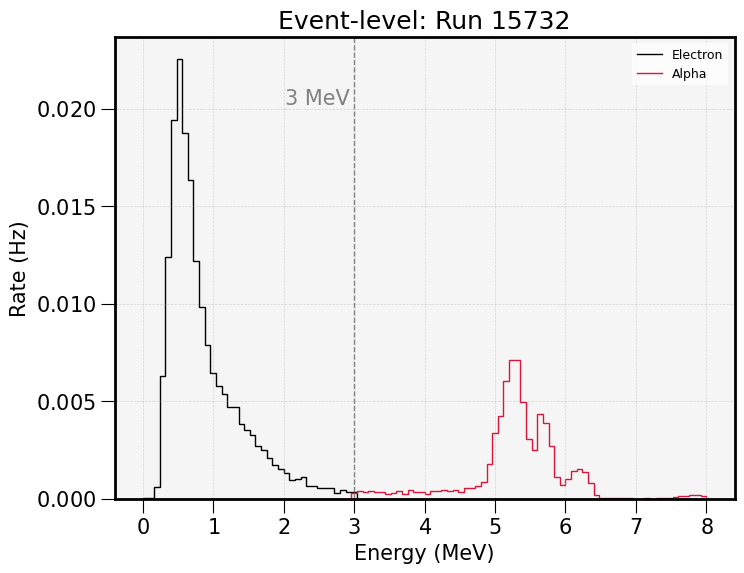

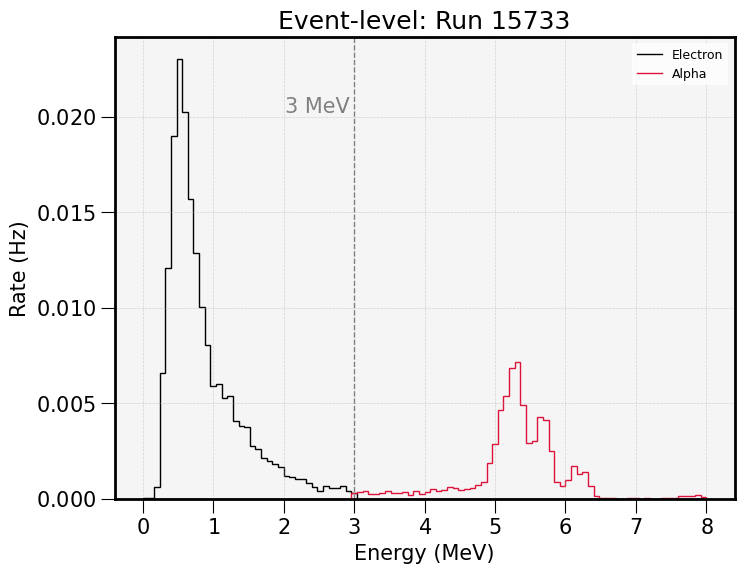

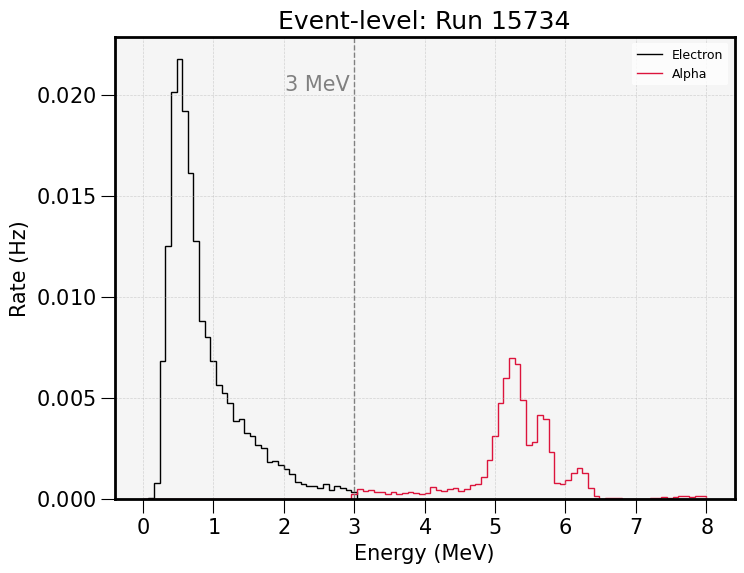

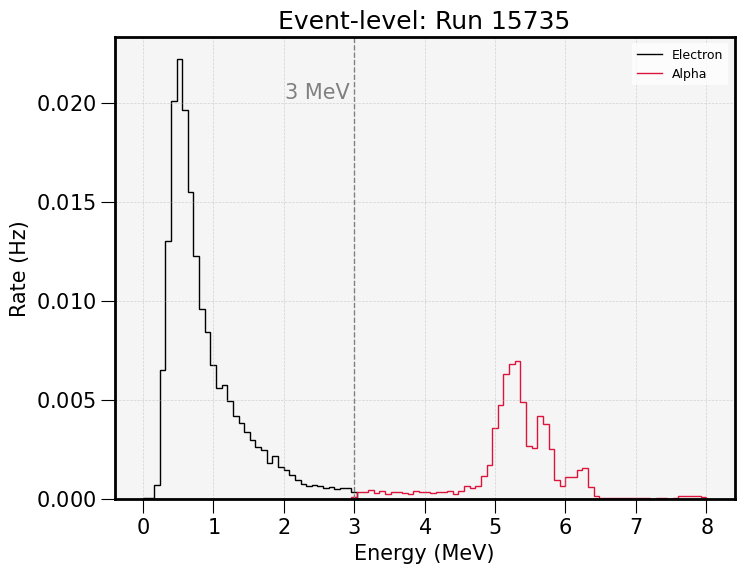

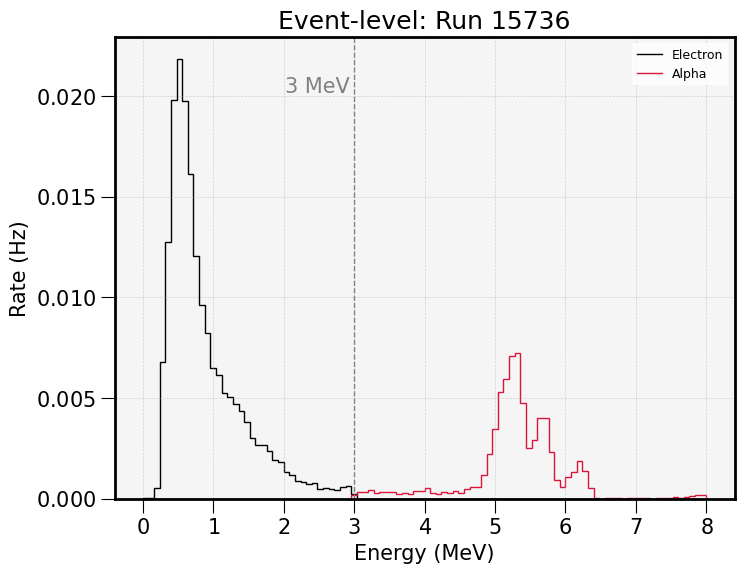

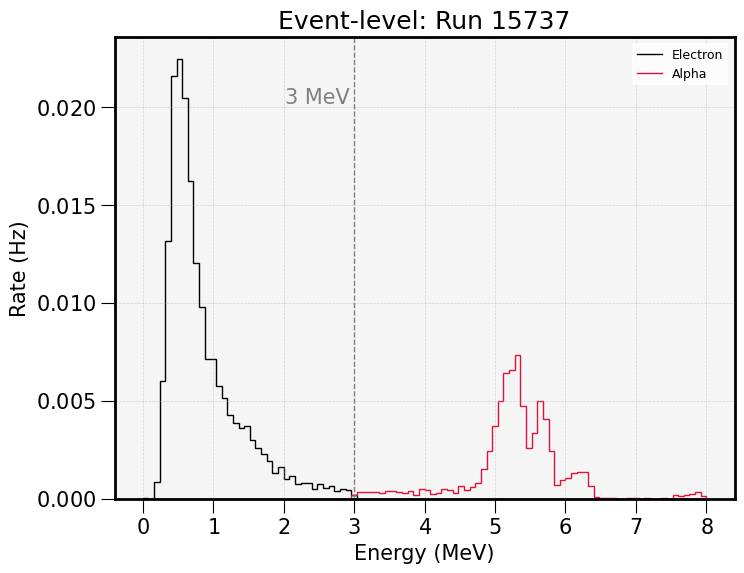

In [20]:
# Global
n_bins = 100
x_min, x_max = 0, 8
x_edges = np.linspace(x_min, x_max, n_bins + 1)

# ----- Run Loop ----- #
for i, run_id in enumerate(RUNS_TO_PROCESS):

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    plt.figure(figsize=(8, 6))

    for j, population in enumerate(['Electron', 'Alpha']):

        # Data
        df_soph = reco_data[run_id]['Sophronia'][population]
        
        # Variables
        E = df_soph.groupby('event')['E_corr'].sum()

        # Histogram: normalized by corrected DAQ data taking time
        E_counts, E_edges = np.histogram(E, bins=x_edges)
        E_rate = E_counts / (run_long * run_DAQe)

        # ----- Plotting ----- #
        plt.stairs(E_rate, E_edges, label=f'{population}', 
                fill=False, lw=1.0, ec=pt.hist_colors[j % len(pt.hist_colors)])

    # Energy threshold
    x_flag = 3
    plt.axvline(x=x_flag, color='gray', ls='--', lw=1)
    plt.text(0.98*x_flag, 2e-2, f'{x_flag} MeV', c='gray', ha='right', va='bottom')

    # ----- Styling ----- #
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Rate (Hz)')
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=9)
    plt.title(f'Event-level: Run {run_id}')

    plt.grid(True, ls='--', lw=0.5, alpha=0.5)
    plt.gca().set_facecolor("whitesmoke")
    plt.show()

## Cleaning Isolated Hits

__Sophronia__
<br>
Clean up those damn spurious hits! Just use the function for $e$ population.
<br>
The cleaning for $\alpha$ population is performed with just a cut on charge at the end of the processing.

### Electrons

In [21]:
# Setting up the filters
NO_hits_sp = crudo.drop_isolated_clusters_3D(distance = [16., 16., 4.], nhit = N_HITS, variables = ['E_corr'])
NO_hits_under_Q = crudo.drop_hits_under_Q_threshold(Q_threshold = Q_THRESHOLD, variables = ['E_corr'])

# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_doro = reco_data[run_id]['Dorothea']['Electron']
    df_soph = reco_data[run_id]['Sophronia']['Electron']
    # Event counter
    evt_prior = df_doro['event'].nunique()
    print(f"  → Electrons ({evt_prior} events, {len(df_soph)} hits) with Qmin = {df_soph['Q'].min()} pe")

    # Drop isolated clusters of hits
    df_evt = df_soph.groupby(['event', 'npeak'], group_keys=False).apply(NO_hits_sp)
    # Drop hits under Q threshold
    df_evt = df_evt.groupby(['event', 'npeak'], group_keys=False).apply(NO_hits_under_Q) 

    df = df_evt.reset_index(drop=True)
    print(f"    Clean Electrons: {df['event'].nunique()} events ({df['event'].nunique()/evt_prior:.2%}), {len(df)} hits with Qmin = {df['Q'].min()} pe \n")
    
    # ----- Good Events ID ----- #
    good_evt = df['event'].unique()
    runs_info[run_id]['Clean_nElectron'] = len(good_evt)

    # ----- Store Data ----- #
    reco_data[run_id]['Dorothea']['Electron']  = df_doro[df_doro['event'].isin(good_evt)].copy()
    reco_data[run_id]['Sophronia']['Electron'] = df.copy()

--- Processing Run 15729 ---
  → Electrons (11733 events, 10801352 hits) with Qmin = 5.0 pe
    Clean Electrons: 11728 events (99.96%), 6001253 hits with Qmin = 5.0 pe 

--- Processing Run 15730 ---
  → Electrons (12135 events, 11228414 hits) with Qmin = 5.0 pe
    Clean Electrons: 12129 events (99.95%), 6289345 hits with Qmin = 5.0 pe 

--- Processing Run 15731 ---
  → Electrons (11903 events, 11208313 hits) with Qmin = 5.0 pe
    Clean Electrons: 11892 events (99.91%), 6312586 hits with Qmin = 5.0 pe 

--- Processing Run 15732 ---
  → Electrons (11843 events, 10943466 hits) with Qmin = 5.0 pe
    Clean Electrons: 11836 events (99.94%), 6144238 hits with Qmin = 5.0 pe 

--- Processing Run 15733 ---
  → Electrons (12087 events, 11225797 hits) with Qmin = 5.0 pe
    Clean Electrons: 12081 events (99.95%), 6331019 hits with Qmin = 5.0 pe 

--- Processing Run 15734 ---
  → Electrons (11888 events, 11074079 hits) with Qmin = 5.0 pe
    Clean Electrons: 11874 events (99.88%), 6201990 hits w

### Alphas

In [22]:
# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_doro = reco_data[run_id]['Dorothea']['Alpha']
    df_soph = reco_data[run_id]['Sophronia']['Alpha']
    # Event counter
    evt_prior = df_doro['event'].nunique()
    print(f"  → Alphas ({evt_prior} events, {len(df_soph)} hits)")

    # Apply charge cut for alpha hits
    df = df_soph[df_soph['Q'] >= Q_LIM_ALPHA].copy()
    print(f"  Clean Alphas: {df['event'].nunique()} events ({df['event'].nunique()/evt_prior:.2%}), {len(df)} hits ")

    # ----- Good Events ID ----- #
    good_evt = df['event'].unique()
    runs_info[run_id]['Clean_nAlpha'] = len(good_evt)

    # ----- Store Data ----- #
    reco_data[run_id]['Dorothea']['Alpha']  = df_doro[df_doro['event'].isin(good_evt)].copy()
    reco_data[run_id]['Sophronia']['Alpha'] = df.copy()

--- Processing Run 15729 ---
  → Alphas (4496 events, 35053266 hits)
  Clean Alphas: 4491 events (99.89%), 1091874 hits 
--- Processing Run 15730 ---
  → Alphas (4633 events, 36415570 hits)
  Clean Alphas: 4633 events (100.00%), 1135649 hits 
--- Processing Run 15731 ---
  → Alphas (4593 events, 36261335 hits)
  Clean Alphas: 4593 events (100.00%), 1123678 hits 
--- Processing Run 15732 ---
  → Alphas (4546 events, 35384138 hits)
  Clean Alphas: 4545 events (99.98%), 1104313 hits 
--- Processing Run 15733 ---
  → Alphas (4549 events, 35343841 hits)
  Clean Alphas: 4549 events (100.00%), 1104220 hits 
--- Processing Run 15734 ---
  → Alphas (4442 events, 34334511 hits)
  Clean Alphas: 4439 events (99.93%), 1079773 hits 
--- Processing Run 15735 ---
  → Alphas (4526 events, 35258738 hits)
  Clean Alphas: 4525 events (99.98%), 1105306 hits 
--- Processing Run 15736 ---
  → Alphas (4938 events, 38517319 hits)
  Clean Alphas: 4934 events (99.92%), 1205757 hits 
--- Processing Run 15737 ---


# Selection

## Data @ Event-level 

Here, a new __event-level__ (different to _Dorothea_) representation of the data is generated. 
<br>
The $XYZ$ position for each event is computed as the energy-weighted sum of constituent hits, defined as:

$X_\text{event} = \frac{\sum E_{\text{hit}}\cdot X_{\text{hit}}}{\sum E_{\text{hit}}}$

In [23]:
# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"--- Processing Run {run_id} ---")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Electron', 'Alpha']:  

        # Data
        df_soph = reco_data[run_id]['Sophronia'][particle]

        # Group sophronia data by event
        soph_evt  = df_soph.groupby('event')
        events_df = []

        for i, event in enumerate(soph_evt):

            # Event info
            event_id   = event[0]
            event_data = event[1]

            # Variables
            T = event_data['time']
            X = event_data['X']
            Y = event_data['Y']
            Z = event_data['Z']
            E = event_data['E_corr']

            # Compute event-level weighted averages and sums
            T_evt = np.mean(T)             # Mean time
            E_evt = np.sum(E)              # Total energy
            X_evt = np.sum(E * X) / E_evt  # Energy-weighted X
            Y_evt = np.sum(E * Y) / E_evt  # Energy-weighted Y
            Z_evt = np.sum(E * Z) / E_evt  # Energy-weighted Z

            # Create a dataframe for the event-level information
            df_evt = pd.DataFrame({'event': [event_id], 'time': [T_evt], 'X': [X_evt], 'Y': [Y_evt], 'Z': [Z_evt], 'E_corr': [E_evt]})
            events_df.append(df_evt)

        # Combine event-level dataframes for the run
        reco_data[run_id]['Event'][particle] = pd.concat(events_df, ignore_index=True)

--- Processing Run 15729 ---
--- Processing Run 15730 ---
--- Processing Run 15731 ---
--- Processing Run 15732 ---
--- Processing Run 15733 ---
--- Processing Run 15734 ---
--- Processing Run 15735 ---
--- Processing Run 15736 ---
--- Processing Run 15737 ---


### Efficiency of the trigger 02

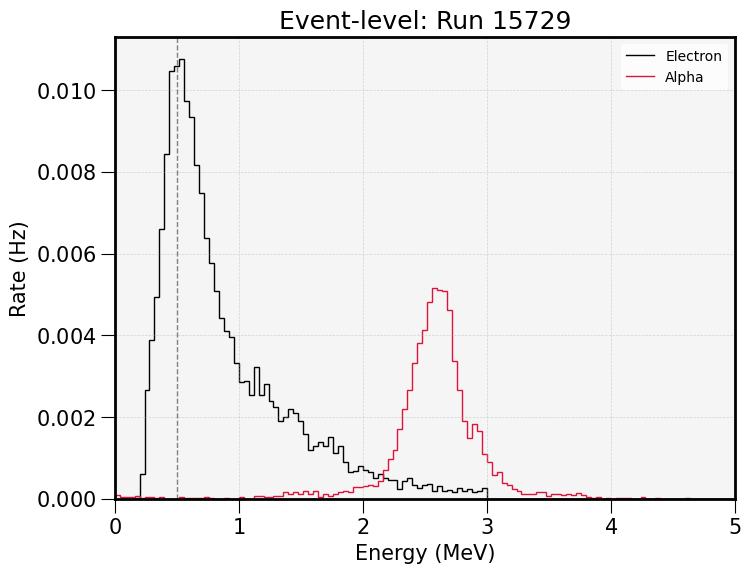

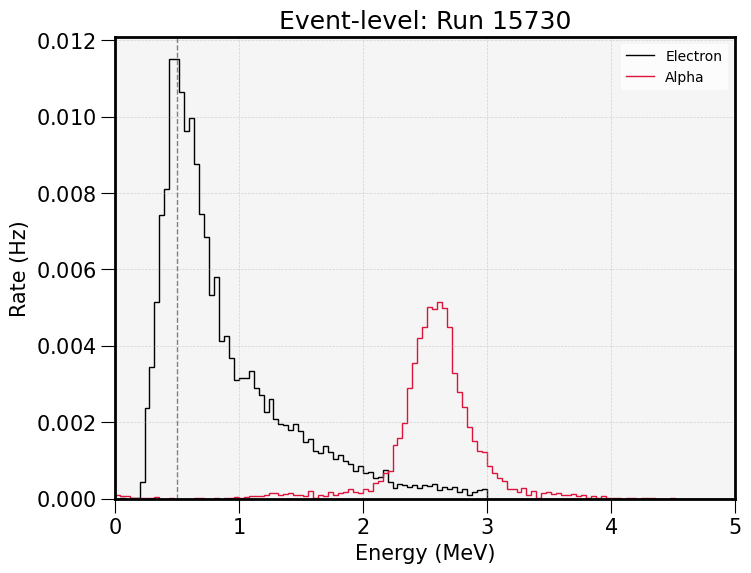

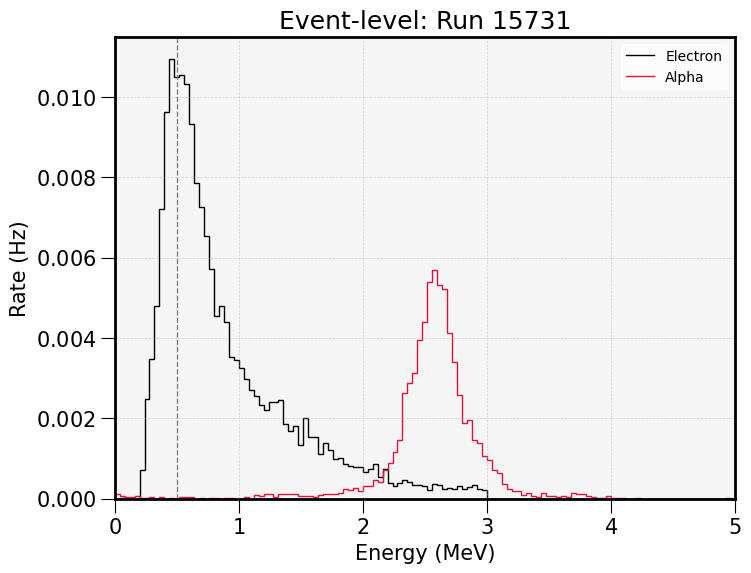

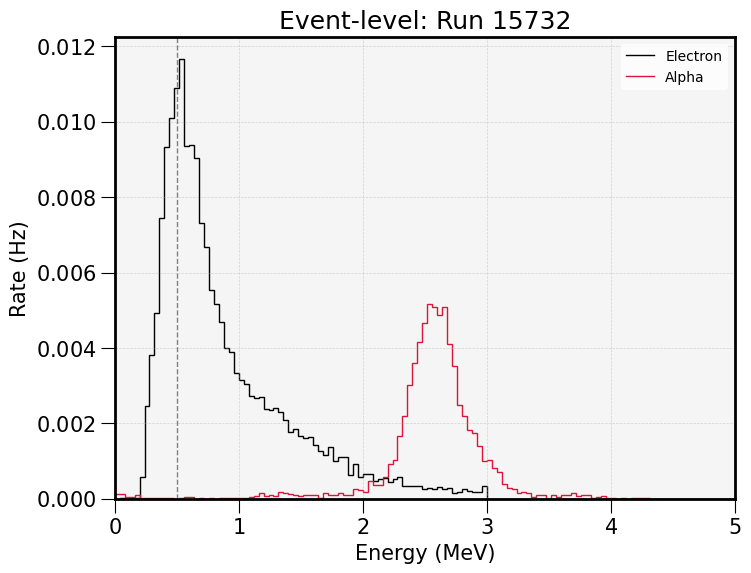

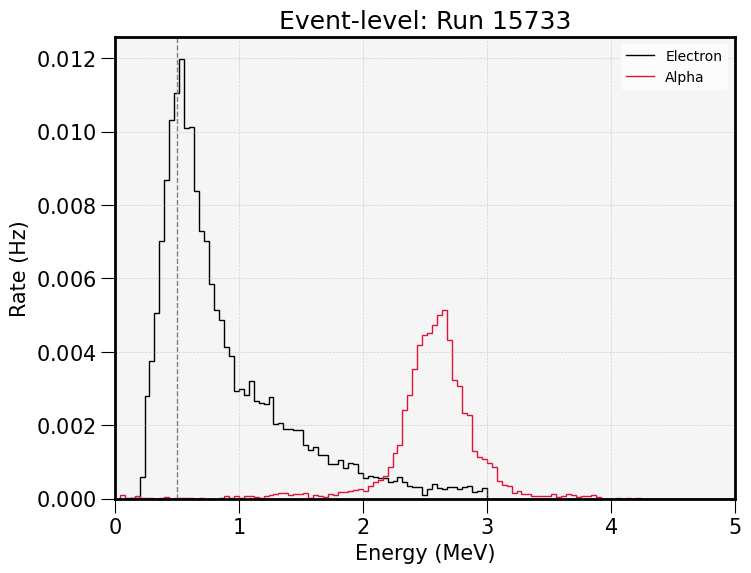

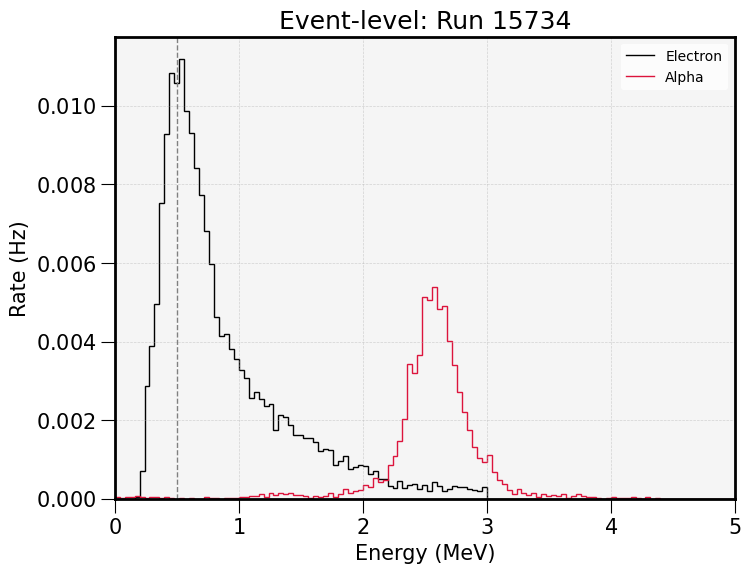

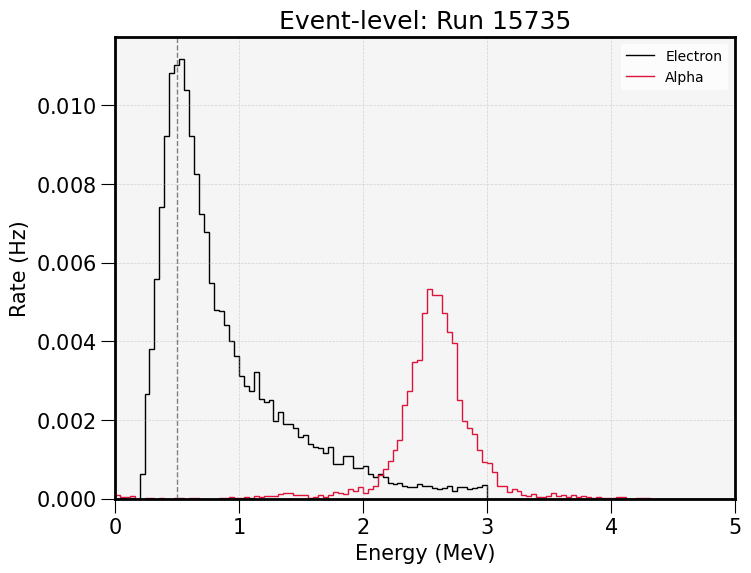

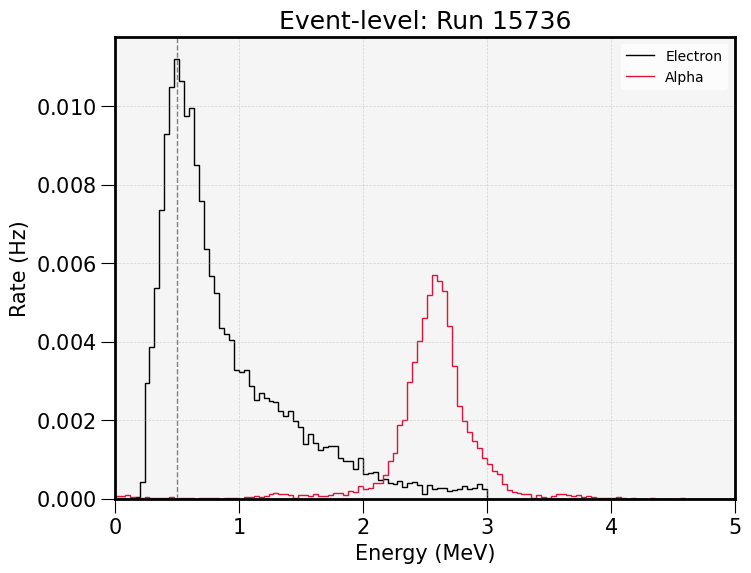

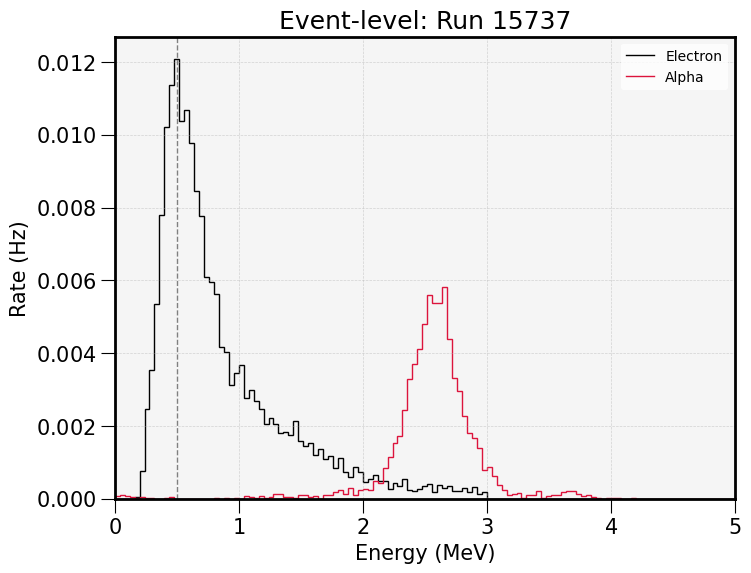

In [24]:
# Global
n_bins = 250
x_min, x_max = 0, 10
x_edges = np.linspace(x_min, x_max, n_bins + 1)

# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    plt.figure(figsize=(8, 6))

    # ----- Plotting for Alphas and Electrons ----- #
    for j, particle in enumerate(['Electron', 'Alpha']):

        # Data
        df = reco_data[run_id]['Event'][particle]
    
        # Variables
        E = df['E_corr']

        # Histogram: normalized by corrected DAQ data taking time
        E_counts, E_edges = np.histogram(E, bins=x_edges)
        E_rate = E_counts / (run_long * run_DAQe)

        # ----- Plotting ----- #
        plt.stairs(E_rate, E_edges, label=f'{particle}', 
                   fill=False, lw=1.0, ec=pt.hist_colors[j % len(pt.hist_colors)])
    

    # Energy threshold due to trigger 2 efficiency
    x_trg2 = 0.5
    plt.axvline(x=x_trg2, color='gray', ls='--', lw=1)

    # Styling
    plt.xlabel('Energy (MeV)')
    plt.xlim(0, 5)
    plt.ylabel('Rate (Hz)')
    # plt.yscale('log')
    # plt.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
    plt.legend(fontsize=10, loc='best')
    plt.title(f'Event-level: Run {run_id}')

    plt.grid(True, ls='--', lw=0.5, alpha=0.5)
    plt.gca().set_facecolor("whitesmoke")
    plt.show()

In [25]:
# Apply selection
for run_id in RUNS_TO_PROCESS:

    print(f"\n--- Processing Run {run_id} ---")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Electron', 'Alpha']:

        # Data
        df_doro = reco_data[run_id]['Dorothea'][particle];       evts_prior = df_doro['event'].nunique()
        df_soph = reco_data[run_id]['Sophronia'][particle]
        df_evt  = reco_data[run_id]['Event'][particle]

        # Event IDs for alphas and electrons
        evt_ids = df_evt.loc[df_evt['E_corr'] >= TRG2_THRESHOLD, 'event'].unique()

        # ----- Storing Data ----- #
        reco_data[run_id]['Dorothea'][particle] = df_doro.loc[df_doro['event'].isin(evt_ids)].copy()
        runs_info[run_id][f'n{particle}_Trg2'] = len(evt_ids)
        print(f"  {particle}: {len(evt_ids)} events ({len(evt_ids)/evts_prior:.2%})")

        reco_data[run_id]['Sophronia'][particle] = df_soph.loc[df_soph['event'].isin(evt_ids)]
        reco_data[run_id]['Event'][particle]     = df_evt.loc[df_evt['event'].isin(evt_ids)]


--- Processing Run 15729 ---
  Electron: 8926 events (76.11%)
  Alpha: 4464 events (99.40%)

--- Processing Run 15730 ---
  Electron: 9236 events (76.15%)
  Alpha: 4605 events (99.40%)

--- Processing Run 15731 ---
  Electron: 8975 events (75.47%)
  Alpha: 4564 events (99.37%)

--- Processing Run 15732 ---
  Electron: 8982 events (75.89%)
  Alpha: 4504 events (99.10%)

--- Processing Run 15733 ---
  Electron: 9212 events (76.25%)
  Alpha: 4527 events (99.52%)

--- Processing Run 15734 ---
  Electron: 8919 events (75.11%)
  Alpha: 4414 events (99.44%)

--- Processing Run 15735 ---
  Electron: 9203 events (75.34%)
  Alpha: 4505 events (99.56%)

--- Processing Run 15736 ---
  Electron: 9976 events (75.66%)
  Alpha: 4903 events (99.37%)

--- Processing Run 15737 ---
  Electron: 5431 events (74.20%)
  Alpha: 2878 events (99.31%)


## Detector Regions

In [26]:
# ----- Run Loop ----- #
for run_id in RUNS_TO_PROCESS:

    print(f"\n--- Processing Run {run_id} ---")
    
    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Electron', 'Alpha']:

        print(f"\n→ {particle}:")

        # Data
        df_doro = reco_data[run_id]['Dorothea'][particle];      evts_prior = df_doro['event'].nunique()
        df_soph = reco_data[run_id]['Sophronia'][particle];     sel_data[run_id]['Sophronia'][particle]['Inclusive'] = df_soph.copy()
        df_evt  = reco_data[run_id]['Event'][particle];         sel_data[run_id]['Event'][particle]['Inclusive'] = df_evt.copy()

        # Event IDs containers for each detector region
        fiducial_ids = []
        tube_ids     = []
        anode_ids    = []
        cathode_ids  = []

        # Events with nS1 = 0: they are anode events!
        NO_S1_evts = df_doro.loc[df_doro['nS1'] == 0, 'event'].unique()
        anode_ids.extend(NO_S1_evts)
        print(f"  NO S1 events: {len(NO_S1_evts)} events...")

        # Ignore these events for the spatial selection
        df_soph_S1 = df_soph[~df_soph['event'].isin(NO_S1_evts)].copy()

        # Group sophronia data by event
        soph_evt = df_soph_S1.groupby('event')

        # Store the event ID for the different detector volumes
        for i, evt in enumerate(soph_evt):
            
            # Event info
            event_id   = evt[0]
            event_data = evt[1]

            # Variables
            R_hits = np.sqrt(event_data['X']**2 + event_data['Y']**2)
            Z_hits = event_data['Z']

            # Maximum and minimum Z and R values
            min_Z = Z_hits.min();  max_Z = Z_hits.max()
            min_R = R_hits.min();  max_R = R_hits.max()            

            # Apply limits by detector region
            if   (min_Z >= Z_LOW) and (max_Z <= Z_UP) and (max_R <= R_UP):    fiducial_ids.append(event_id)
            elif (min_Z >= Z_LOW) and (max_Z <= Z_UP) and (max_R >  R_UP):    tube_ids.append(event_id)
            elif (min_Z <  Z_LOW):                                            anode_ids.append(event_id)
            elif (max_Z >  Z_UP):                                             cathode_ids.append(event_id)

        # Ensure no duplicate event IDs across regions
        assert len(set(fiducial_ids).intersection(tube_ids)) == 0,    "Duplicate event IDs found between fiducial and tube regions"
        assert len(set(fiducial_ids).intersection(anode_ids)) == 0,   "Duplicate event IDs found between fiducial and anode regions"
        assert len(set(fiducial_ids).intersection(cathode_ids)) == 0, "Duplicate event IDs found between fiducial and cathode regions"
        assert len(set(tube_ids).intersection(anode_ids)) == 0,       "Duplicate event IDs found between tube and anode regions"
        assert len(set(tube_ids).intersection(cathode_ids)) == 0,     "Duplicate event IDs found between tube and cathode regions"
        assert len(set(anode_ids).intersection(cathode_ids)) == 0,    "Duplicate event IDs found between anode and cathode regions"

        # ----- Storing Data ----- #
        sel_data[run_id]['Sophronia'][particle]['Fiducial'] = df_soph.loc[df_soph['event'].isin(fiducial_ids)].copy()
        sel_data[run_id]['Sophronia'][particle]['Tube']     = df_soph.loc[df_soph['event'].isin(tube_ids)].copy()
        sel_data[run_id]['Sophronia'][particle]['Anode']    = df_soph.loc[df_soph['event'].isin(anode_ids)].copy()
        sel_data[run_id]['Sophronia'][particle]['Cathode']  = df_soph.loc[df_soph['event'].isin(cathode_ids)].copy()
        
        sel_data[run_id]['Event'][particle]['Fiducial'] = df_evt.loc[df_evt['event'].isin(fiducial_ids)].copy()
        sel_data[run_id]['Event'][particle]['Tube']     = df_evt.loc[df_evt['event'].isin(tube_ids)].copy()
        sel_data[run_id]['Event'][particle]['Anode']    = df_evt.loc[df_evt['event'].isin(anode_ids)].copy()
        sel_data[run_id]['Event'][particle]['Cathode']  = df_evt.loc[df_evt['event'].isin(cathode_ids)].copy()

        # ----- Printing Extra Information ----- #
        runs_info[run_id][f'n{particle}_Fiducial'] = len(fiducial_ids)
        print(f"  Fiducial: {len(fiducial_ids)} events ({len(fiducial_ids)/evts_prior:.2%}) || Rate = {len(fiducial_ids)/(run_long * run_DAQe):.2e} Hz")

        runs_info[run_id][f'n{particle}_Tube']     = len(tube_ids)
        print(f"  Tube:     {len(tube_ids)} events ({len(tube_ids)/evts_prior:.2%})")

        runs_info[run_id][f'n{particle}_Anode']    = len(anode_ids)
        print(f"  Anode:    {len(anode_ids)} events ({len(anode_ids)/evts_prior:.2%})")

        runs_info[run_id][f'n{particle}_Cathode']  = len(cathode_ids)       
        print(f"  Cathode:  {len(cathode_ids)} events ({len(cathode_ids)/evts_prior:.2%})")


--- Processing Run 15729 ---

→ Electron:
  NO S1 events: 874 events...
  Fiducial: 213 events (2.39%) || Rate = 3.28e-03 Hz
  Tube:     6867 events (76.93%)
  Anode:    969 events (10.86%)
  Cathode:  877 events (9.83%)

→ Alpha:
  NO S1 events: 155 events...
  Fiducial: 915 events (20.50%) || Rate = 1.41e-02 Hz
  Tube:     583 events (13.06%)
  Anode:    155 events (3.47%)
  Cathode:  2811 events (62.97%)

--- Processing Run 15730 ---

→ Electron:
  NO S1 events: 873 events...
  Fiducial: 252 events (2.73%) || Rate = 3.82e-03 Hz
  Tube:     7174 events (77.67%)
  Anode:    996 events (10.78%)
  Cathode:  814 events (8.81%)

→ Alpha:
  NO S1 events: 138 events...
  Fiducial: 969 events (21.04%) || Rate = 1.47e-02 Hz
  Tube:     558 events (12.12%)
  Anode:    138 events (3.00%)
  Cathode:  2940 events (63.84%)

--- Processing Run 15731 ---

→ Electron:
  NO S1 events: 901 events...
  Fiducial: 249 events (2.77%) || Rate = 3.81e-03 Hz
  Tube:     6878 events (76.64%)
  Anode:    989 e

# Output

### Dataframes

In [27]:
# ----- Run Loop ----- #
for run_id, data in sel_data.items():

    # ----- Store Extra Info ----- #
    # Reco data
    doro_df = reco_data[run_id]['Dorothea']['All']
    
    # # Ignore runs
    # if run_id in [15688]:
    #     continue

    # Run date
    date_CV  = doro_df['time'].mean()
    date_err = doro_df['time'].std() / np.sqrt(len(doro_df['time']))

    runs_info[run_id]['Date_CV']  = date_CV
    runs_info[run_id]['Date_Err'] = date_err

    # ----- Save DataFrames to HDF5 ----- #
    # Output filename
    h5_name = f'run_{run_id}{VERSION_TAG}.h5'
    h5_path = os.path.join(OUTPUT_DIR, h5_name)

    print(f"\n--- Run {run_id}: Saving data to {os.path.basename(h5_path)} ---")

    crudo.save_dataframes(data, h5_path)


--- Run 15729: Saving data to run_15729_p2_nhit5.h5 ---
    Saved DataFrame to key: 'Sophronia/Alpha/Inclusive' (1091024, 11)
    Saved DataFrame to key: 'Sophronia/Alpha/Fiducial' (213970, 11)
    Saved DataFrame to key: 'Sophronia/Alpha/Tube' (121676, 11)
    Saved DataFrame to key: 'Sophronia/Alpha/Anode' (24423, 11)
    Saved DataFrame to key: 'Sophronia/Alpha/Cathode' (730955, 11)
    Saved DataFrame to key: 'Sophronia/Electron/Inclusive' (5365418, 11)
    Saved DataFrame to key: 'Sophronia/Electron/Fiducial' (124411, 11)
    Saved DataFrame to key: 'Sophronia/Electron/Tube' (3674971, 11)
    Saved DataFrame to key: 'Sophronia/Electron/Anode' (940966, 11)
    Saved DataFrame to key: 'Sophronia/Electron/Cathode' (625070, 11)
    Saved DataFrame to key: 'Event/Alpha/Inclusive' (4464, 6)
    Saved DataFrame to key: 'Event/Alpha/Fiducial' (915, 6)
    Saved DataFrame to key: 'Event/Alpha/Tube' (583, 6)
    Saved DataFrame to key: 'Event/Alpha/Anode' (155, 6)
    Saved DataFrame to ke

### Summary

Open the current extra information text file

In [28]:
# ----- .txt with Runs Extra Info ----- #
txt_path = os.path.join("/lhome/ific/c/ccortesp/Analysis/NEXT-100/Backgrounds/txt/", OUTPUT_TXT)
print(f"Output text file: {txt_path}")

Output text file: /lhome/ific/c/ccortesp/Analysis/NEXT-100/Backgrounds/txt/summary_p2_nhit5.txt


In [29]:
if os.path.exists(txt_path):
    print(f"Warning: The file '{txt_path}' already exists and will be overwritten.")
    Oldie_extra_info_df = pd.read_csv(
                                        txt_path,
                                        sep="\t",
                                        index_col='Run_ID'
                                    )

else:
    Oldie_extra_info_df = pd.DataFrame()

Create the summary dataframe for recent processed runs

In [30]:
# Filter runs_info to include only the RUNS_TO_PROCESS
filtered_runs_info = {run_id: runs_info[run_id] for run_id in RUNS_TO_PROCESS}

# Summary dataframe
Summary_df = pd.DataFrame.from_dict(filtered_runs_info, orient='index')
Summary_df.index.name = 'Run_ID'

Combine both dataframes, sort by _Run_ID_ and save it again!

In [31]:
# Combine the summary dataframe with the old extra info dataframe
Extra_info_df = pd.concat([Oldie_extra_info_df, Summary_df])

# Sort the combined dataframe by Run_ID
Extra_info_df = Extra_info_df.sort_index()

In [32]:
# # Reorganizar las columnas en el orden deseado
# column_order = [
#     # Información global sobre el run
#     'duration', 'Date_CV',  'Date_Err', 'OK', 'LOST', 'Reco_CV',

#     # Información de cortes conjuntos
#     'After_Zneg', 'nS1_0', 'nS1_1', 'nS1_NOPolike', 'After_S1', 'After_S2',

#     # Información de selección de electrones
#     'nElectron', 'Clean_nElectron', 'nElectron_Trg2', 'nElectron_Fiducial',
#     'nElectron_Tube', 'nElectron_Anode', 'nElectron_Cathode',

#     # Información de selección de alphas
#     'nAlpha', 'Clean_nAlpha', 'nAlpha_Trg2', 'nAlpha_Fiducial',
#     'nAlpha_Tube', 'nAlpha_Anode', 'nAlpha_Cathode'
# ]

# # Reorganizar las columnas del DataFrame
# Extra_info_df = Extra_info_df[column_order]

In [33]:
Extra_info_df

,duration,Date_CV,Date_Err,OK,LOST,Reco_CV,After_Zneg,nS1_0,nS1_1,nS1_NOPolike,...,nElectron_Tube,nElectron_Anode,nElectron_Cathode,nAlpha,Clean_nAlpha,nAlpha_Trg2,nAlpha_Fiducial,nAlpha_Tube,nAlpha_Anode,nAlpha_Cathode
Run_ID,,,,,,,,,,,,,,,,,,,,,
15609,79563,1.753150e+09,178.505400,28168,8392,27865,20667,2139,17560,15564,...,6926,992,834,4566,4566,4541,1009,530,104,2898
15614,81279,1.753243e+09,184.991900,28543,8472,28225,20811,2232,17470,15432,...,6845,964,828,4425,4424,4408,950,509,115,2834
15615,86302,1.753328e+09,189.789700,30165,9046,29767,21927,2436,18414,16198,...,7074,1104,880,4714,4713,4680,1030,604,125,2921
15616,86146,1.753414e+09,189.687600,30386,8635,30124,22198,2414,18742,16505,...,7178,1060,895,4902,4901,4876,1014,640,145,3077
15617,88041,1.753502e+09,189.154500,31274,8983,31052,22945,2534,19324,17057,...,7541,1114,915,4919,4918,4896,1012,589,139,3156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15733,86919,1.758939e+09,193.830371,30475,10027,30144,22120,2437,18639,16226,...,7054,1060,857,4549,4549,4527,916,547,147,2917
15734,85790,1.759026e+09,195.073299,29837,9598,29513,21813,2406,18158,15869,...,6863,1010,834,4442,4439,4414,852,546,113,2903
15735,87451,1.759113e+09,194.430986,30547,9958,30193,22198,2495,18665,16315,...,7100,1008,860,4526,4525,4505,868,534,145,2958


In [34]:
# ----- Save .txt with Runs Extra Info ----- #
Extra_info_df.to_csv(
                        txt_path,          
                        sep='\t',
                        index=True,
                        index_label='Run_ID',
                        float_format='%.4f'
)

print(f"Successfully updated and saved the master summary to '{os.path.basename(txt_path)}'.")

Successfully updated and saved the master summary to 'summary_p2_nhit5.txt'.


# Tests

In [ ]:
test_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/runs/'
# test_h5 = "run_15635_sel_data.h5"
test_h5 = "run_15539_old_sel.h5"

test_path = os.path.join(test_dir, test_h5)

test_key = 'Sophronia/Electron/Fiducial'

In [ ]:
test_soph = pd.read_hdf(test_path, key=test_key)

In [ ]:
test_soph.min()

event          1.075700e+04
time           1.750084e+09
npeak          0.000000e+00
Xpeak         -1.598341e+02
Ypeak         -1.563336e+02
nsipm          1.000000e+00
X             -4.359750e+02
Y             -4.332750e+02
Xrms           0.000000e+00
Yrms           0.000000e+00
Z              5.064037e+01
Q              7.000267e+00
E              1.500868e+00
Qc            -1.000000e+00
Ec             7.610587e-06
track_id      -1.000000e+00
Ep            -1.000000e+00
corr_factor    4.907041e-06
E_corr         7.953326e-06
Z_real         4.380392e+01
dtype: float64

In [32]:
info_15632 = pd.read_csv(
                                        './NEXT-100/Backgrounds/txt/run_15632_versions.txt',
                                        sep="\t",
                                        index_col='Run_ID'
                                    )

In [33]:
info_15632

,test,duration,OK,LOST,Reco_CV,After_Zneg,nS1_0,nS1_1,nS1_NOPolike,After_S1,...,nElectron_Fiducial,nElectron_Tube,nElectron_Anode,nElectron_Cathode,nAlpha_Fiducial,nAlpha_Tube,nAlpha_Anode,nAlpha_Cathode,Date_CV,Date_Err
Run_ID,,,,,,,,,,,,,,,,,,,,,
15632,1,86709,30444,8826,30078,22169,2548,19036,16383,18931,...,226,6550,952,699,997,604,80,3017,1.754356e+09,190.7012
15632,2,86709,30444,8826,30078,22169,2545,18595,16261,18806,...,265,6955,1071,885,996,628,144,3053,1.754356e+09,190.7012
15632,3,86709,30444,8826,30078,22169,2545,18595,16261,18806,...,271,6953,1070,882,996,628,144,3053,1.754356e+09,190.7012
